# Simulating asset returns with random walks

- *Continuous* random walk: The return is the derivative of the risky asset value S, and the safe asset value B
- We model the risky asset's prices like this:

$$ \frac{dS_t}{S_t} = \underbrace{(r + \sigma \lambda)}_{=\mu} dt + \sigma d W_t $$

- $S_t$ is the asset price at time $t$
- $\mu$ is the expected return (called the *drift* in the process)
  - $r$ is the risk free rate
  - $\sigma$ is the stock's volatility
  - $\lambda$ is the Sharpe ratio on that stock
- $dt$ is e.g. 1 month or 12 months  
- $W_t$ is the **Brownian motion** process, a continuous-time random walk

$$ \frac{dB_t}{B_t} = rdt \Leftrightarrow B_t = B_0 e^{rt} $$

# Discrete time formulation

Understand Brownian motion better by looking at discrete time first.


$$ \frac{dS_t}{S_t} = \frac{S_{t+dt}-S_t}{S_t} = (r+\sigma \lambda)dt+\sigma\sqrt{dt}\xi_t $$

- $\xi_t$ is a random variable with mean 0 and unit variance

# MC Simulation with time varying parameters

Before, we set the risk free rate $r$ to be fix over time. But it (like other parameters) varies, so it should be $r_t$!

A more general model:

$$ \frac{dS_t}{S_t} = (r_t + \underbrace{\sqrt{V_t}}_{=\sigma_t} \lambda_t^S) dt + \sqrt{V_t} dW_t^S $$

**Note**: It's not $W_t$ to the power of $S$, but it's the $W$ that *belongs* to the asset price $S$. Cause we'll have more $W$'s in a second


Let's introduce stochastic processes for the riskfree rate and the variance, to allow them to evolve over time:

$$dr_t = a(b-r_t)dt + \sigma_r dW_t^r$$

$a(b-r_t)$ is the deterministic component with a **mean-reverting feature**. $b$ is the long-term mean of the process. The Brownian motion $W_t$ is the random component.

$$dV_t = \alpha(\bar{V} - V_t)dt + \sigma_V\sqrt{V_t}dW_t^V$$

The $\sqrt{V_t}$ before the Brownian motion scales down the movement as the variance approaches zero from above. This ensures the variance's process will never become negative.

# Lab: Random Walk Generation

We'll implement this model, a [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion):

$$\frac{S_{t+dt}-S_t}{S_t} = \mu dt + \sigma \sqrt{dt} \xi_t$$

It's a [Stochastic Differential Equation (SDE)](https://en.wikipedia.org/wiki/Stochastic_differential_equation). You can also write it as

$$dS_t = \mu S_t dt + \sigma S_t \sqrt{dt} dW_t$$

$\xi_t$ is a random Brownian motion $N(0,1)$, it's just a different character for $dW_t$.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def gbm_slow(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """A discretized (to `steps_per_year`) Geometric Brownian Motion generator.
    It simulates the evolution of a stock price.
    The mu and sigma defaults are annualized returns for the stock market.
    s_0 is the starting stock price"""
    
    # delta-time:
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    
    # Generate a table: Each row is the new stock price, and each column is one possible scenario:
    xi = np.random.normal(size=(n_steps, n_scenarios))
    # Returns:
    rets = mu*dt + sigma*np.sqrt(dt)*xi
    rets = pd.DataFrame(rets)
    # To prices:
    prices = s_0*(1+rets).cumprod()
    
    return prices

In [14]:
def gbm(n_years=10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0):
    """A discretized (to `steps_per_year`) Geometric Brownian Motion generator.
    It simulates the evolution of a stock price.
    The mu and sigma defaults are annualized returns for the stock market.
    s_0 is the starting stock price"""
    
    # delta-time:
    dt = 1/steps_per_year
    n_steps = int(n_years * steps_per_year)
    
    # Generate a table: Each row is the new stock price, and each column is one possible scenario:
    rets_plus_1 = np.random.normal(loc=1+mu*dt, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1  # start the time series with price=100, not price=103.15 e.g.
    # To prices:
    prices = s_0*pd.DataFrame(rets_plus_1).cumprod()
    
    return prices

In [15]:
# %timeit gbm_slow(n_years=5, n_scenarios=1000)

385 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# %timeit gbm(n_years=5, n_scenarios=1000)

195 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
p = gbm(n_scenarios=20)

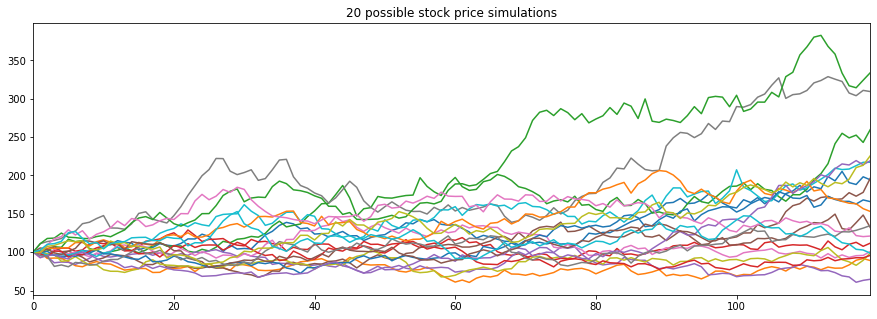

In [19]:
p.plot(legend=False, figsize=(15,5), title="20 possible stock price simulations")

# Analyzing CPPI strategies

In this video, he plotted these portfolio developments in a Shiny-like app, and then the same with using CPPI. The values never dropped below \$70.

$m=1$ means you put only your cushion in the risky asset. Then you will never have a threshold violation, but you're too conservative, too slow in growth.